In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import InSituData, InSituExperiment, CACHE
import scanpy as sc
from tqdm import tqdm
import pandas as pd

In [3]:
data_path = Path(r"E:\ColorectalCancer\analysis\proseg_only")

In [4]:
exp = InSituExperiment.read(data_path)
exp.load_all()

100%|██████████| 7/7 [00:30<00:00,  4.36s/it]


In [5]:
exp

InSituExperiment with 7 samples:
           uid  CITAR  slide_id       sample_id  Region  ...  Metastasis type     H number              HE           panCK annotations_Tanja
0     3d377351  ++++-      3621  Region_1-14...       1  ...             NaN   1414/18 IIA  C:\Users\ge...  C:\Users\ge...  E:\Colorect...  
1     039bf1f8  ++++-      3621  Region_2-14...       2  ...     synchronous   1414/18 IIS  C:\Users\ge...  C:\Users\ge...  E:\Colorect...  
2     1c928862  ++++-      3621  Region_3-33...       3  ...    asynchronous   3311/18 IVA  C:\Users\ge...  C:\Users\ge...  E:\Colorect...  
3     18755ab6  ++++-      3621  Region_4-14...       4  ...     synchronous    1414/18 IC  C:\Users\ge...  C:\Users\ge...  E:\Colorect...  
4     3ee0776f  ++++-      3991  Region_1-53...       1  ...             NaN   5316/18 IVC  C:\Users\ge...  C:\Users\ge...  E:\Colorect...  
5     4e08eb69  ++++-      3991  Region_2-53...       2  ...     synchronous   5316/18 IVS  C:\Users\ge...  C:\Users\ge..

In [6]:
exp.metadata

uid  slide_id             sample_id  Region  Patient      Tissue  \
0  3d377351      3621  Region_1-1414_18_IIA       1        1       Colon   
1  039bf1f8      3621  Region_2-1414_18_IIS       2        1  Lymph node   
2  1c928862      3621  Region_3-3311_18_IVA       3        1        Lung   
3  18755ab6      3621   Region_4-1414_18_IC       4        1       Liver   
4  3ee0776f      3991  Region_1-5316_18_IVC       1        2       Colon   
5  4e08eb69      3991   Region_2-5316_18_IV       2        2  Lymph node   
6  c20dbd1b      3991    Region_3-1367_19_A       3        2        Lung   

            Type            Sample Name Metastasis type     H number  \
0  primary tumor      Colorectal Cancer             NaN  1414/18 IIA   
1     metastasis  Lymph node metastasis     synchronous  1414/18 IIS   
2     metastasis        Lung metastasis    asynchronous  3311/18 IVA   
3     metastasis       Liver metastasis     synchronous   1414/18 IC   
4  primary tumor      Colorectal Cancer             NaN  5316/18 IVC   
5     metastasis  Lymph node metastasis     synchronous  5316/18 IVS   
6     metastasis        Lung metastasis    asynchronous    1367/19 A   

                                                  HE  \
0  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   
1  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   
2  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   
3  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   
4  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   
5  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   
6  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   

                                               panCK  \
0  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   
1  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   
2  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   
3  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   
4  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   
5  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   
6  C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...   

                                   annotations_Tanja  
0  E:\ColorectalCancer\annotations_Tanja\exports\...  
1  E:\ColorectalCancer\annotations_Tanja\exports\...  
2  E:\ColorectalCancer\annotations_Tanja\exports\...  
3  E:\ColorectalCancer\annotations_Tanja\exports\...  
4  E:\ColorectalCancer\annotations_Tanja\exports\...  
5  E:\ColorectalCancer\annotations_Tanja\exports\...  
6  E:\ColorectalCancer\annotations_Tanja\exports\...

## Differential gene expression analysis

Performed separately for each sample using Wilcoxon rank-sum test. Afterwards, we check in how many samples the genes are significantly upregulated.

In [7]:
from insitupy.utils import create_deg_dataframe

deg_results = {}
for meta, xd in exp.iterdata():
    print(meta["sample_id"])
    # get anndata and select only cancer cells
    adata = xd.cells["proseg"].matrix
    cancer_sample = adata[adata.obs["cell_type"].str.contains("Cancer cell")].copy()

    # perform DGE analysis
    sc.tl.rank_genes_groups(
        adata=cancer_sample,
        groupby="cell_type",
        groups="all",
        reference="rest",
        method="wilcoxon",
        key_added="deg_cancer_cells"
    )

    # collect results
    deg_results[meta["sample_id"]] = create_deg_dataframe(adata=cancer_sample, key="deg_cancer_cells")

Region_1-1414_18_IIA
Region_2-1414_18_IIS
Region_3-3311_18_IVA
Region_4-1414_18_IC
Region_1-5316_18_IVC
Region_2-5316_18_IV
Region_3-1367_19_A


Genes are thresholded based on z-score and logfold change.

In [38]:
import pandas as pd
import numpy as np
import collections
import seaborn as sns
import matplotlib.pyplot as plt

# get names of all cancer cell subtypes
cell_types = sorted([elem for elem in exp.data[0].cells.matrix.obs["cell_type"].cat.categories if elem.startswith("Cancer cell")])

# parameters for thresholding
zscore_thresh = 10
#p_thresh = 0.05
lfc_thresh = np.log2(1.5)

# setup a dictionary for the results
counter_res = {
    "up": {},
    "down": {}
}
for cell_type in cell_types:
    up_dict = {}
    down_dict = {}
    for k, d in deg_results.items():
        df = d[cell_type]

        # create masks
        z_mask = df["scores"].abs() > zscore_thresh
        #p_mask = df["pvals"] < p_thresh
        lfc_mask = df["logfoldchanges"].abs() > lfc_thresh

        # do filtering
        #df_filtered = df[z_mask & p_mask & lfc_mask]
        df_filtered = df[z_mask & lfc_mask]

        # select up and downregulated genes
        df_up = df_filtered[df_filtered["logfoldchanges"] > 0].sort_values("logfoldchanges", ascending=False)
        df_down = df_filtered[df_filtered["logfoldchanges"] < 0].sort_values("logfoldchanges", ascending=True)

        # collect data
        up_dict[k] = df_up
        down_dict[k] = df_down

    # determine number of samples in which the genes are upregulated
    up_lists = [elem["gene"].tolist() for elem in up_dict.values()]
    down_lists = [elem["gene"].tolist() for elem in down_dict.values()]
    up_flat = np.array([elem for sublist in up_lists for elem in sublist])
    down_flat = np.array([elem for sublist in down_lists for elem in sublist])
    up_counts = collections.Counter(up_flat)
    down_counts = collections.Counter(down_flat)

    # collect results
    counter_res["up"][cell_type] = up_counts
    counter_res["down"][cell_type] = down_counts

In [39]:
counter_df_up = {}
for k, d in counter_res["up"].items():
    dd = pd.DataFrame.from_dict(d, orient='index')
    dd.columns = ["count"]
    counter_df_up[k] = dd
counter_df_up = pd.concat(counter_df_up)

counter_df_down = {}
for k, d in counter_res["down"].items():
    dd = pd.DataFrame.from_dict(d, orient='index')
    dd.columns = ["count"]
    counter_df_down[k] = dd
counter_df_down = pd.concat(counter_df_down)

In [40]:
def plot_bars(data, color, savepath=None):
    g = sns.FacetGrid(data, col="Subtype",col_wrap=4,
                    height=3, aspect=0.8,
                    sharey=True, sharex=False)
    g.map(sns.barplot, "Gene", "Count", color=color, edgecolor='black')

    g.set_ylabels("Number of\nsamples")
    g.set_titles("{col_name}")
    g.figure.subplots_adjust(wspace=0.1, hspace=1)

    # Rotate x-axis labels for better readability
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(90)
            label.set_ha('center')

    # add horizontal line at y=6.5
    for ax in g.axes.flat:
        ax.axhline(y=6.5, color='black', linestyle='--')

    if savepath is not None:
        plt.savefig(savepath, bbox_inches="tight")

    plt.show()

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


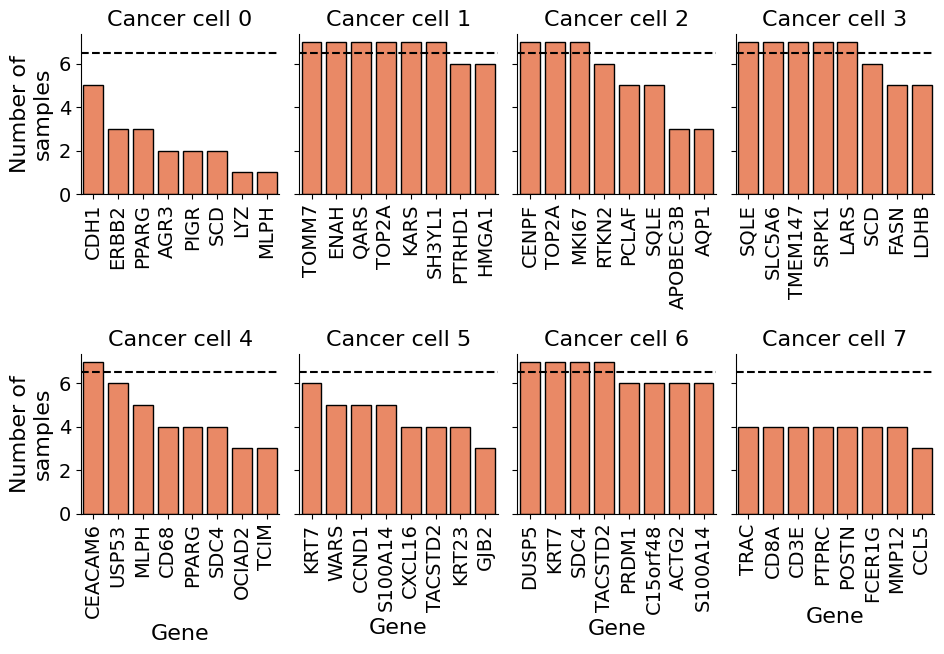

In [41]:
data = counter_df_up.reset_index()
data.columns = ["Subtype", "Gene", "Count"]
data = data.sort_values(['Subtype', 'Count'], ascending=[True, False]).groupby('Subtype').head(8)
plot_bars(data, color="coral", savepath="figures/bars_number_sig_genes_up.pdf")

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


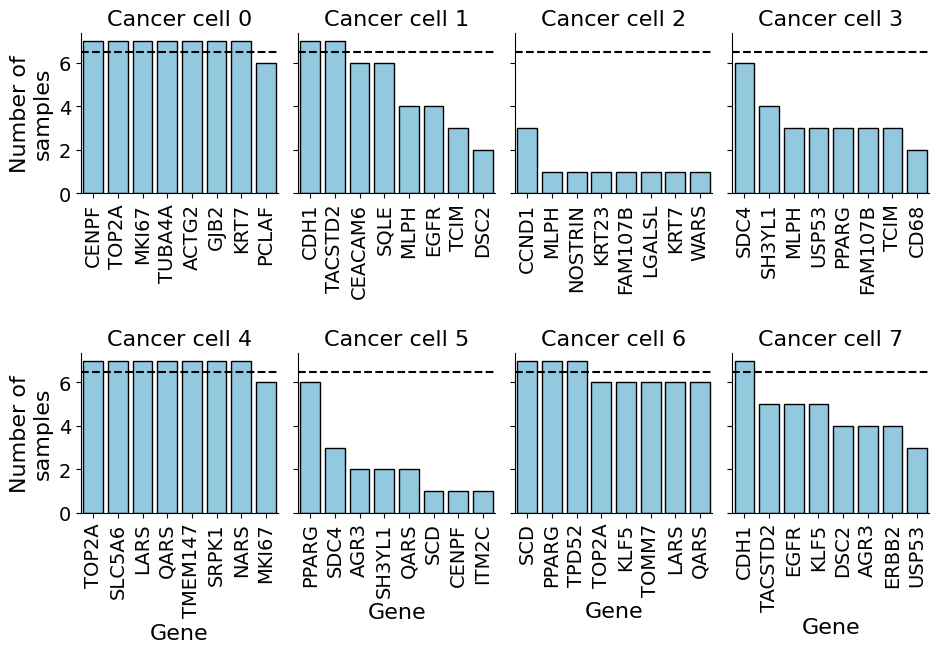

In [42]:
data = counter_df_down.reset_index()
data.columns = ["Subtype", "Gene", "Count"]
data = data.sort_values(['Subtype', 'Count'], ascending=[True, False]).groupby('Subtype').head(8)
plot_bars(data, color="skyblue", savepath="figures/bars_number_sig_genes_down.pdf")

Get up-regulated genes in Cancer cell subtype 6.

In [43]:
count_thresh = 7
up_genes_dict = {}
for k, v in counter_res["up"].items():
    l = [key.item() for key, count in v.items() if count >= count_thresh]
    if len(l) > 0:
        up_genes_dict[k] = l

down_genes_dict = {}
for k, v in counter_res["down"].items():
    l = [key.item() for key, count in v.items() if count >= count_thresh]
    if len(l) > 0:
        down_genes_dict[k] = l

In [44]:
up_genes_dict

{'Cancer cell 1': ['TOMM7', 'ENAH', 'QARS', 'TOP2A', 'KARS', 'SH3YL1'],
 'Cancer cell 2': ['CENPF', 'TOP2A', 'MKI67'],
 'Cancer cell 3': ['SQLE', 'SLC5A6', 'TMEM147', 'SRPK1', 'LARS'],
 'Cancer cell 4': ['CEACAM6'],
 'Cancer cell 6': ['DUSP5', 'KRT7', 'SDC4', 'TACSTD2']}

In [45]:
down_genes_dict

{'Cancer cell 0': ['CENPF',
  'TOP2A',
  'MKI67',
  'TUBA4A',
  'ACTG2',
  'GJB2',
  'KRT7'],
 'Cancer cell 1': ['CDH1', 'TACSTD2'],
 'Cancer cell 4': ['TOP2A',
  'SLC5A6',
  'LARS',
  'QARS',
  'TMEM147',
  'SRPK1',
  'NARS'],
 'Cancer cell 6': ['SCD', 'PPARG', 'TPD52'],
 'Cancer cell 7': ['CDH1']}

In [46]:
up_counts_of_interest = counter_res["up"]["Cancer cell 6"]
down_counts_of_interest = counter_res["down"]["Cancer cell 6"]
count_thresh = 7
up_genes = [key.item() for key, count in up_counts_of_interest.items() if count >= count_thresh]
down_genes = [key.item() for key, count in down_counts_of_interest.items() if count >= count_thresh]

In [47]:
up_genes = up_genes_dict["Cancer cell 6"]
down_genes = down_genes_dict["Cancer cell 6"]

In [48]:
up_genes

['DUSP5', 'KRT7', 'SDC4', 'TACSTD2']

In [49]:
down_genes

['SCD', 'PPARG', 'TPD52']

Plot expression of up/down regulated genes in subtype 6.

In [50]:
adata = exp.collect_anndatas(
    cells_layer="proseg", label_col="sample_id",
    obs_keys=["majority_voting_simple", "cell_type"],
    obsm_keys=["X_umap_scanvi", "annotations"],
    uns_keys='cell_type_colors'

    )
adata.obs_names_make_unique()
cancer = adata[adata.obs["cell_type"].str.contains("Cancer cell")].copy()

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


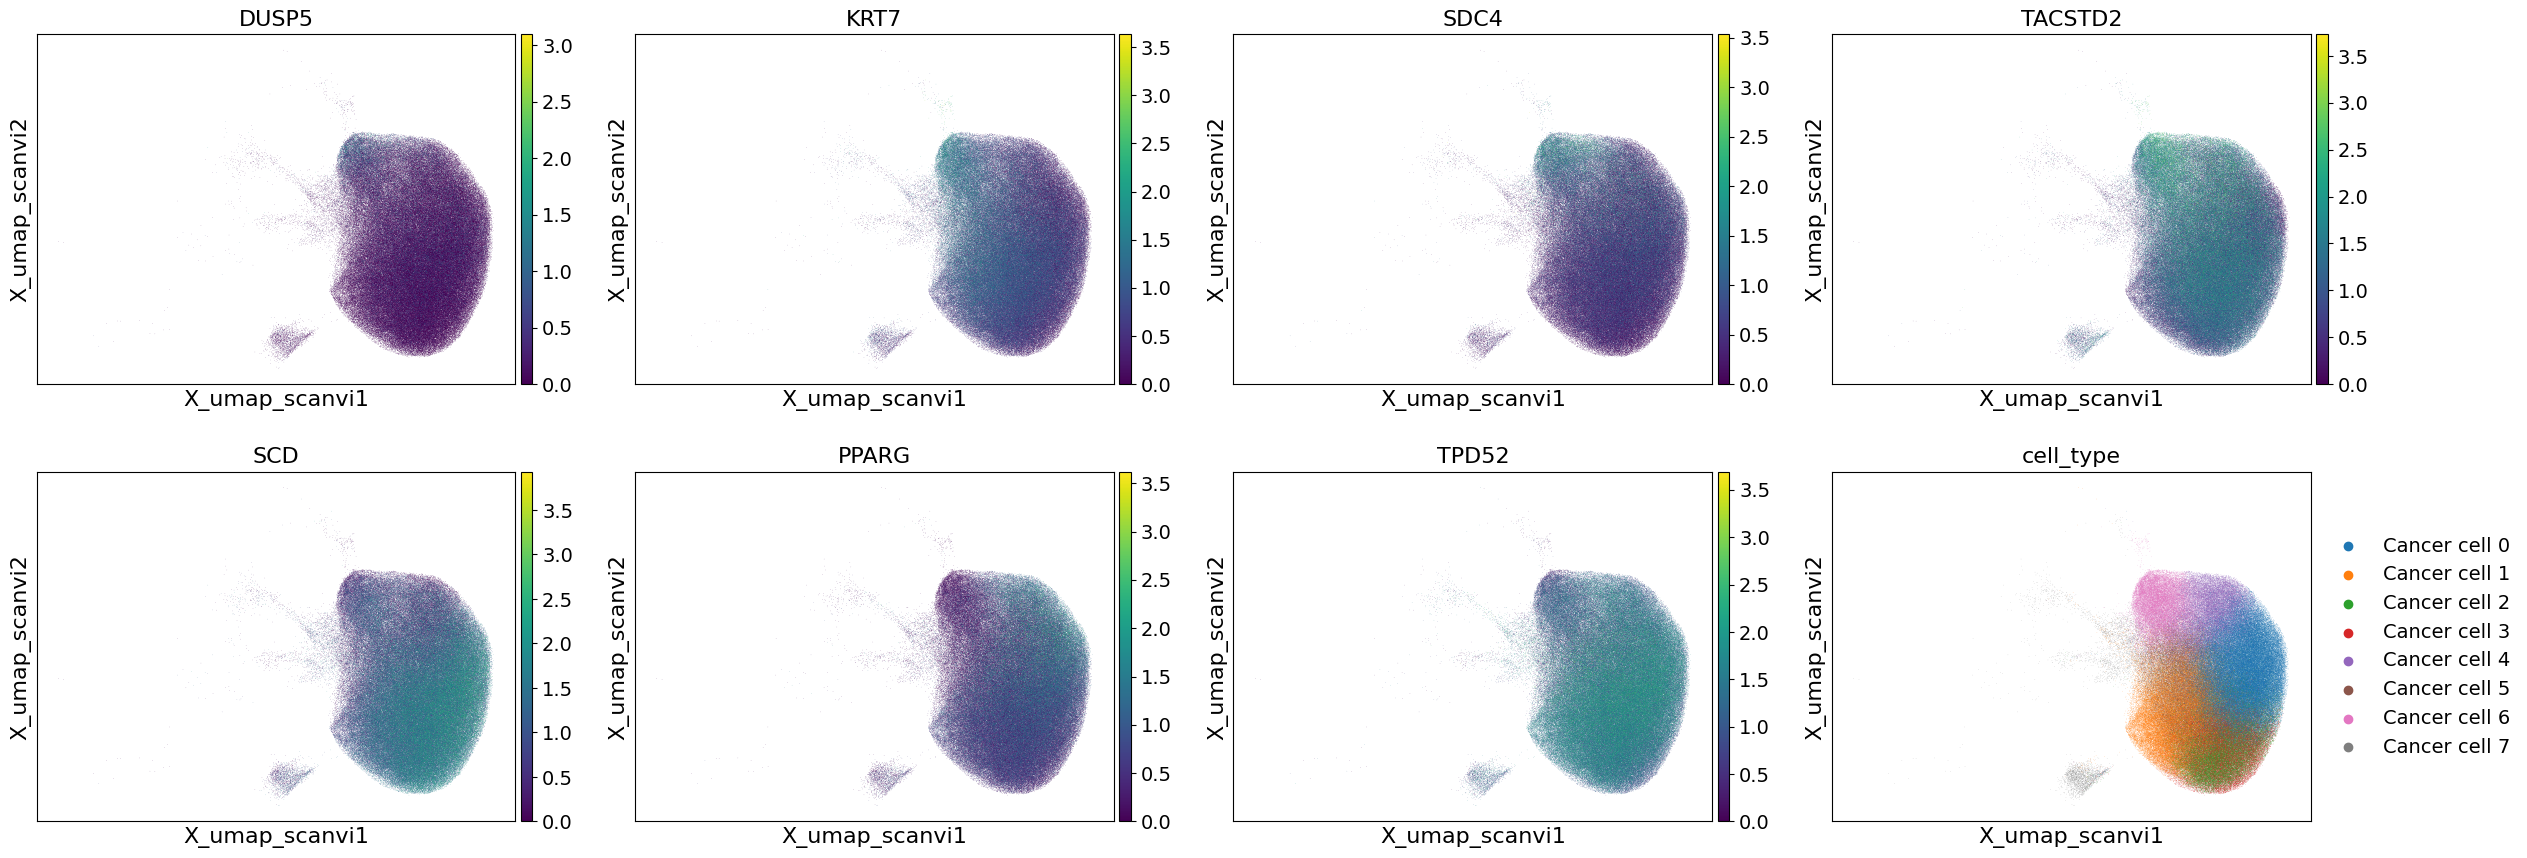

In [51]:
sc.pl.embedding(
    cancer,
    basis="X_umap_scanvi",
    color=up_genes + down_genes + ["cell_type"],
    save="_subtype6_updown_genes.png"
    )

In [52]:
up_genes_dict

{'Cancer cell 1': ['TOMM7', 'ENAH', 'QARS', 'TOP2A', 'KARS', 'SH3YL1'],
 'Cancer cell 2': ['CENPF', 'TOP2A', 'MKI67'],
 'Cancer cell 3': ['SQLE', 'SLC5A6', 'TMEM147', 'SRPK1', 'LARS'],
 'Cancer cell 4': ['CEACAM6'],
 'Cancer cell 6': ['DUSP5', 'KRT7', 'SDC4', 'TACSTD2']}

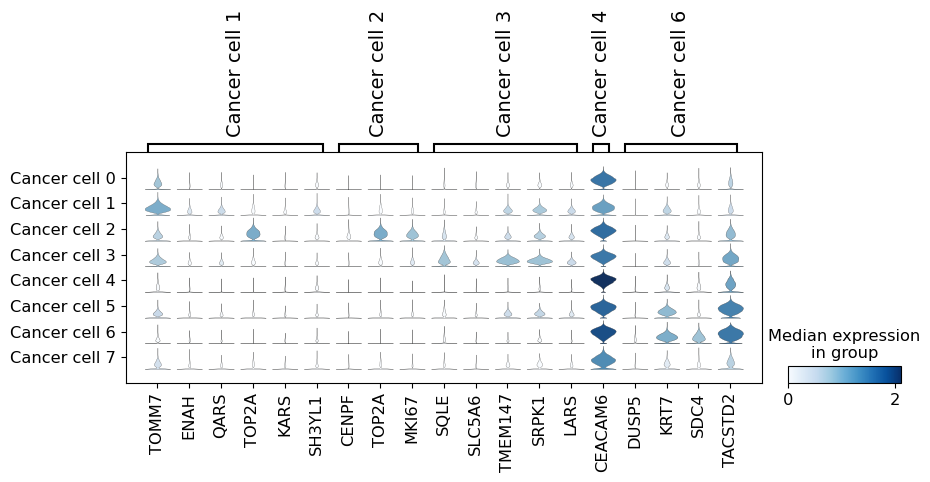

In [57]:
sc.pl.stacked_violin(
    cancer,
    var_names=up_genes_dict,
    groupby="cell_type",
    #swap_axes=True,
    figsize=(10,3),
    #save="_marker_genes_cancer.pdf"
    )

## Heatmap

The top upregulated genes could now be shown in a pseudobulk heatmap to show that they are up-regulated across all samples.

## Literature

### Cancer subtype 6

#### Upregulated genes
- SDC4 (Syndecan-4):
    - [Jechorek et al](https://pubmed.ncbi.nlm.nih.gov/34029877/)
        - important functions in cell adhesion, migration, cytoskeleton organization
        - found to be up-regulated at the tumor invasion front
        - Expression was strongest in tumor cell buds appearing as membranous expression polarized to peritumoral stromal cells
        - predictor for poor prognosis
    - [Zhou et al.](https://www.nature.com/articles/s41598-025-00793-x)
        - SDC4 is significantly overexpressed in 16 types of tumors and positively correlated with poor prognosis in four types of these diseases (including colorectal cancer)
- KRT7: 
    - [An et al.]((https://pubmed.ncbi.nlm.nih.gov/33416175/))
        - Increase in expression of KRT7 during EMT in ovarian cancer 
    - [Jiang et al.](https://www.nature.com/articles/s41598-024-84129-1)Promotes cancer metastasis in PDAC
    - [Harbaum et al.](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2559.2011.03694.x?casa_token=D5JRVlZd5K4AAAAA%3A3QDJAWIYm2vZRG2zyANurlRoGH36LEhgIEw-d1SMm8amrJ_3RP_Kfi5ot-FGgniDPjl57BJwa2Zu7w)
        - KRT7 expression was associated with poor tumor differentiation and the extent of tumor budding. 
        - KRT7 expression was found to be enriched in single cells and small clusters of cells at the invasion front (confirming our results)
        - correlated with poor prognosis
- TACSTD2 (TROP2):
    - [Siskova et al.](https://www.biorxiv.org/content/10.1101/2024.10.29.620817v1):
        - early marker of CRC formation
    - [Gehring et al.](https://www.nature.com/articles/s41598-024-52437-1)
        - powerful driver of colorectal cancer
    - [Svec et al.](https://pmc.ncbi.nlm.nih.gov/articles/PMC9454662/)
        - TROP2 expression correlates with lymph node metastasis and poor tumor differentiation
    - [Foersch et al.](https://pmc.ncbi.nlm.nih.gov/articles/PMC11342791/)
        - TROP2 significantly correlated with an invasive phenotype and advanced tumor stage.
- DUSP5:
    - [Yan et al.](https://pmc.ncbi.nlm.nih.gov/articles/PMC5088295/)
        - negative regulator of MAPK signaling pathway and identified as tumor suppressor in several malignancies
        - found to be lower in tumor tissue than normal tissue
        - positive prognostic indicator for patients with advanced colorectal cancer (high expression with better prognosis)
    - Janssen: https://www.journalonko.de/gastrointestinale-tumoren/kolorektales-karzinom/kolorektalkarzinom-rolle-dusp5
    - [Tögel et al.](https://www.nature.com/articles/s41598-018-20176-9)
        - methylated in CIMP-high CRC but was found to be not a major regulator of intestinal cell proliferation and tumorigenesis
            - we found indeed that the proliferation is rather reduced in subtype 6 while DUSP5 is higher.
    - [Kidger et al.](https://pubmed.ncbi.nlm.nih.gov/35418690/)
        - negative regulator of RAS/ERK signalling
        



#### Downregulated genes
- PPARG
    - [Schöckel](https://bmccancer.biomedcentral.com/articles/10.1186/s12885-024-11985-5):
        - both pro- and anti-tumor properties described
        - Patients **without distant metastases** had a significantly longer overall survival with low PPARG expression in their tumours compared to patients with high PPARG expression
        - In the **pulmonary metastasis cohort** instead, a trend towards longer survival was observed for patients with high PPARG expression in their tumour
        - Activation of PPARG significantly increased sensitivity of cell lines to 5-FU (inhibition decreased it)
        - prognostic effect of PPARG expression depends on the metastasis localization in advanced CRC patients
    - Multifaceted role: https://www.eurekaselect.com/article/4809
- SCD
    - [Wang et al.](https://pubmed.ncbi.nlm.nih.gov/40061980/):
        - found to be signficantly upregulated in CRC

- TPD52
    - [Li et al.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0178515):
        - shown to be involved in tumorigenesis of various cancers
        - prognostic value in CRC patients
        - highly expressed in primary carcinoma compared to non-cancerous tissue
        - frequent overexpression in liver metastases compared to primary carcinoma
    - [Tennstedt et al.](https://www.spandidos-publications.com/10.3892/ijo.2013.2200#b60-ijo-44-02-0609):
        - upregulation of TPD52 found in CRC
    


#### General trends
- Both SCD (fatty acid biosynthesis) and PPARG (downstream genes stimulate lipid uptake and adipogenesis by fat cells) are involved in lipid metabolism



### Old results
- PIM1:
    - proto-oncogene that promotes proliferation, survival and metastasis, among others (https://biosignaling.biomedcentral.com/articles/10.1186/s12964-024-01898-y)
    - https://pmc.ncbi.nlm.nih.gov/articles/PMC5980151/:
        - makes cancer cells less vulnerable to glucose starvation by blocking the Warburg effect 
        - positively correlated with CRC progression

    - 
- CDH1 (E-cadherin)
    - [Gupta et al.](https://www.sciencedirect.com/science/article/pii/S0092867409007818):
        - Downregulation of CDH1 is key feature of EMT
    - [Kim et al.](https://pubmed.ncbi.nlm.nih.gov/26742007/):
        - Associated with tumor growth and metastasis in CRC


In [58]:
from insitupy.plotting import volcano_plot
from insitupy.utils.utils import get_nrows_maxcols, remove_empty_subplots

In [60]:
up_genes_dict

{'Cancer cell 1': ['TOMM7', 'ENAH', 'QARS', 'TOP2A', 'KARS', 'SH3YL1'],
 'Cancer cell 2': ['CENPF', 'TOP2A', 'MKI67'],
 'Cancer cell 3': ['SQLE', 'SLC5A6', 'TMEM147', 'SRPK1', 'LARS'],
 'Cancer cell 4': ['CEACAM6'],
 'Cancer cell 6': ['DUSP5', 'KRT7', 'SDC4', 'TACSTD2']}

In [62]:
cell_types

['Cancer cell 0',
 'Cancer cell 1',
 'Cancer cell 2',
 'Cancer cell 3',
 'Cancer cell 4',
 'Cancer cell 5',
 'Cancer cell 6',
 'Cancer cell 7']

Cancer cell 0


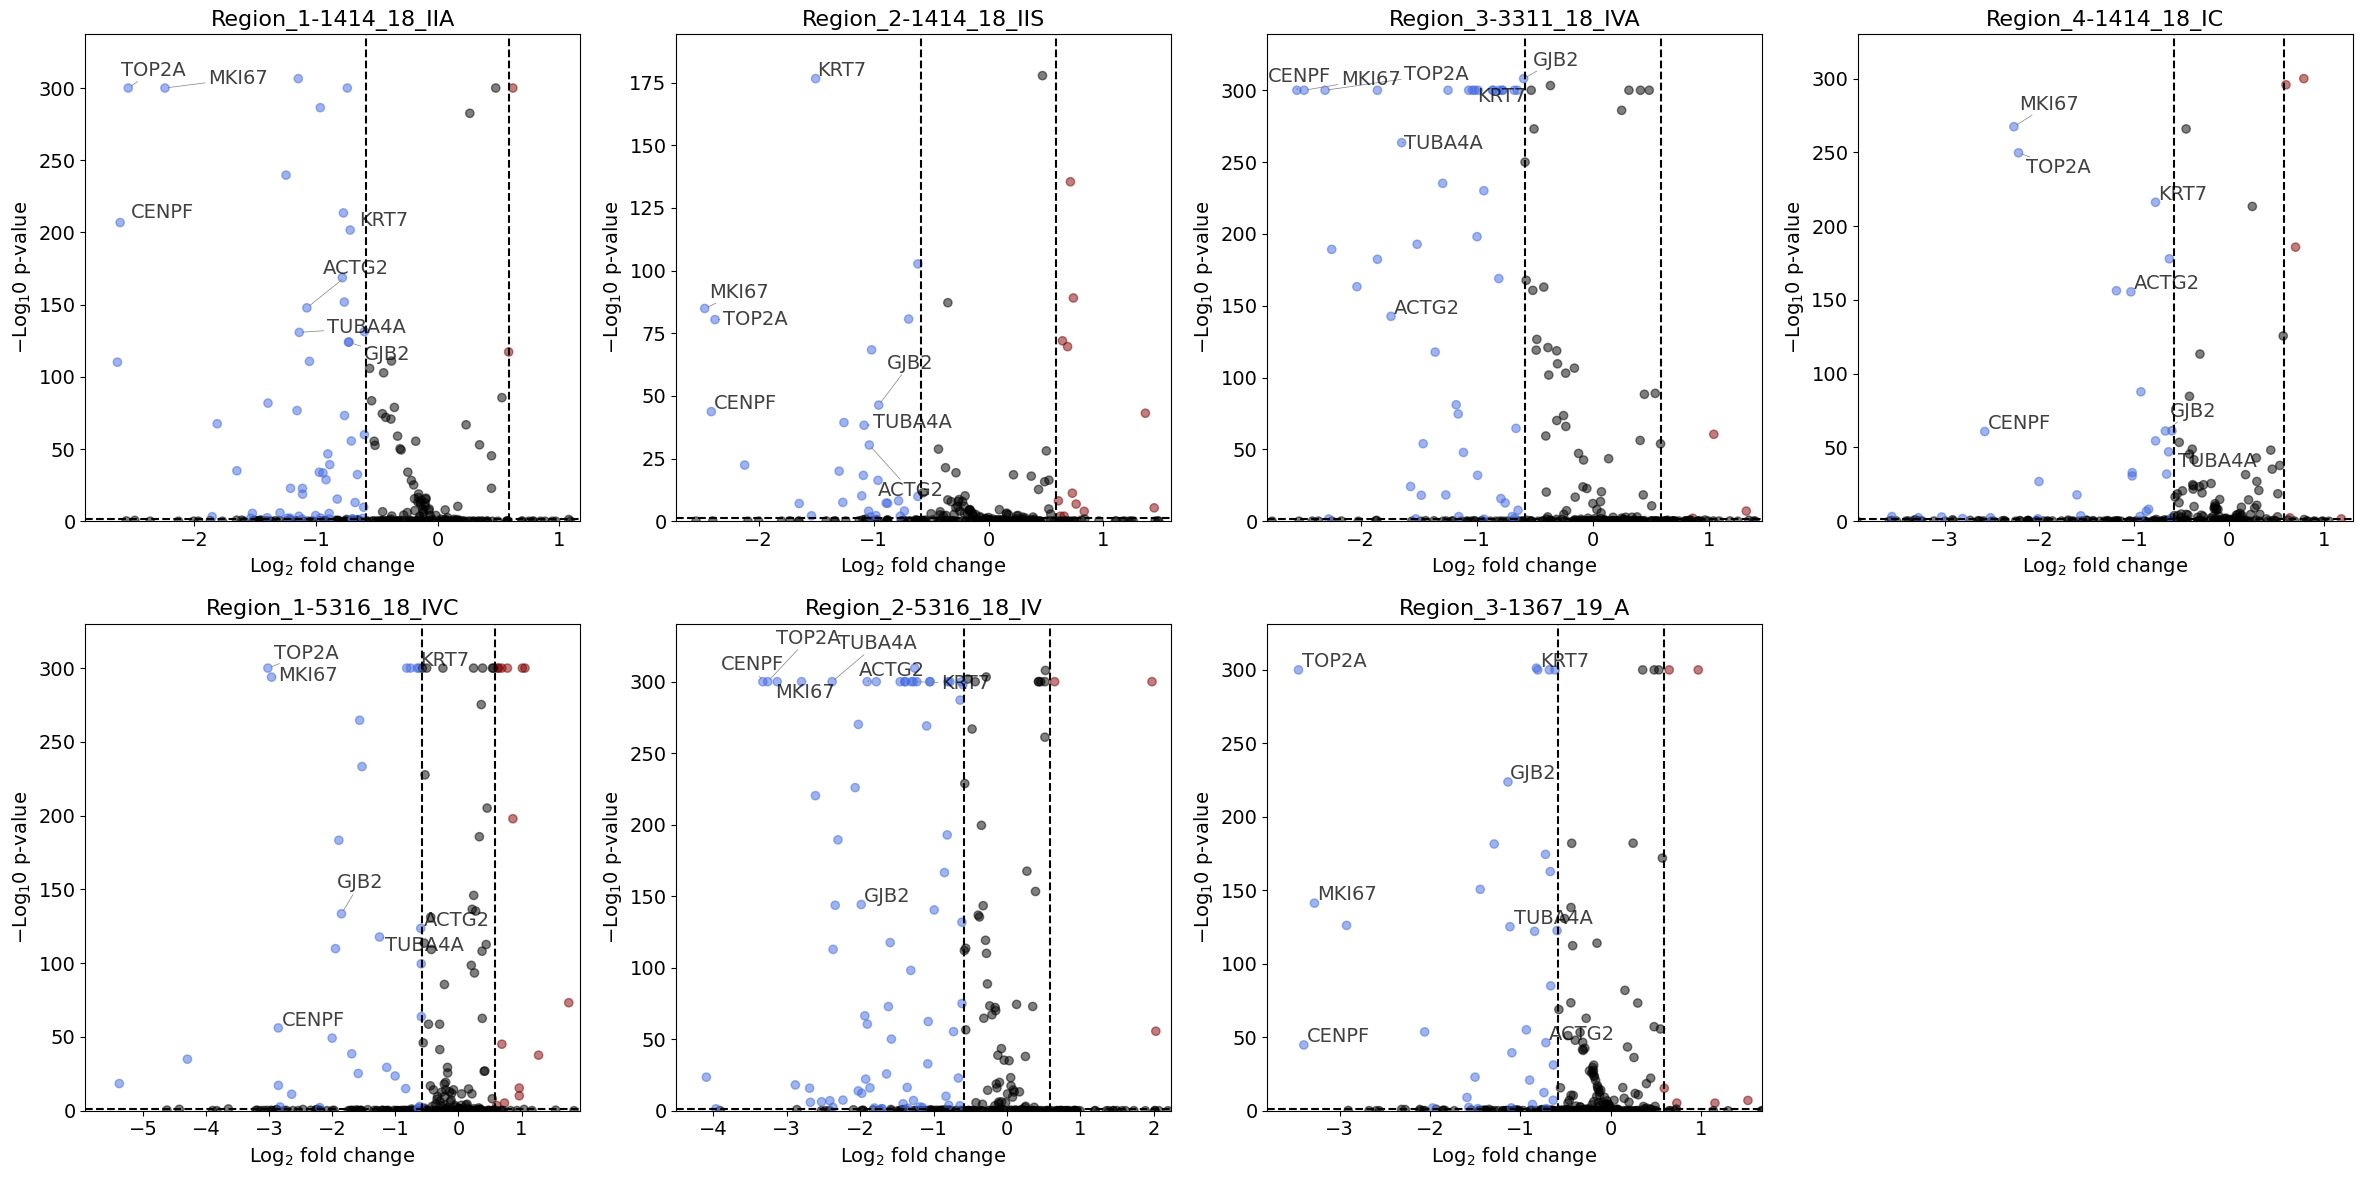

Cancer cell 1


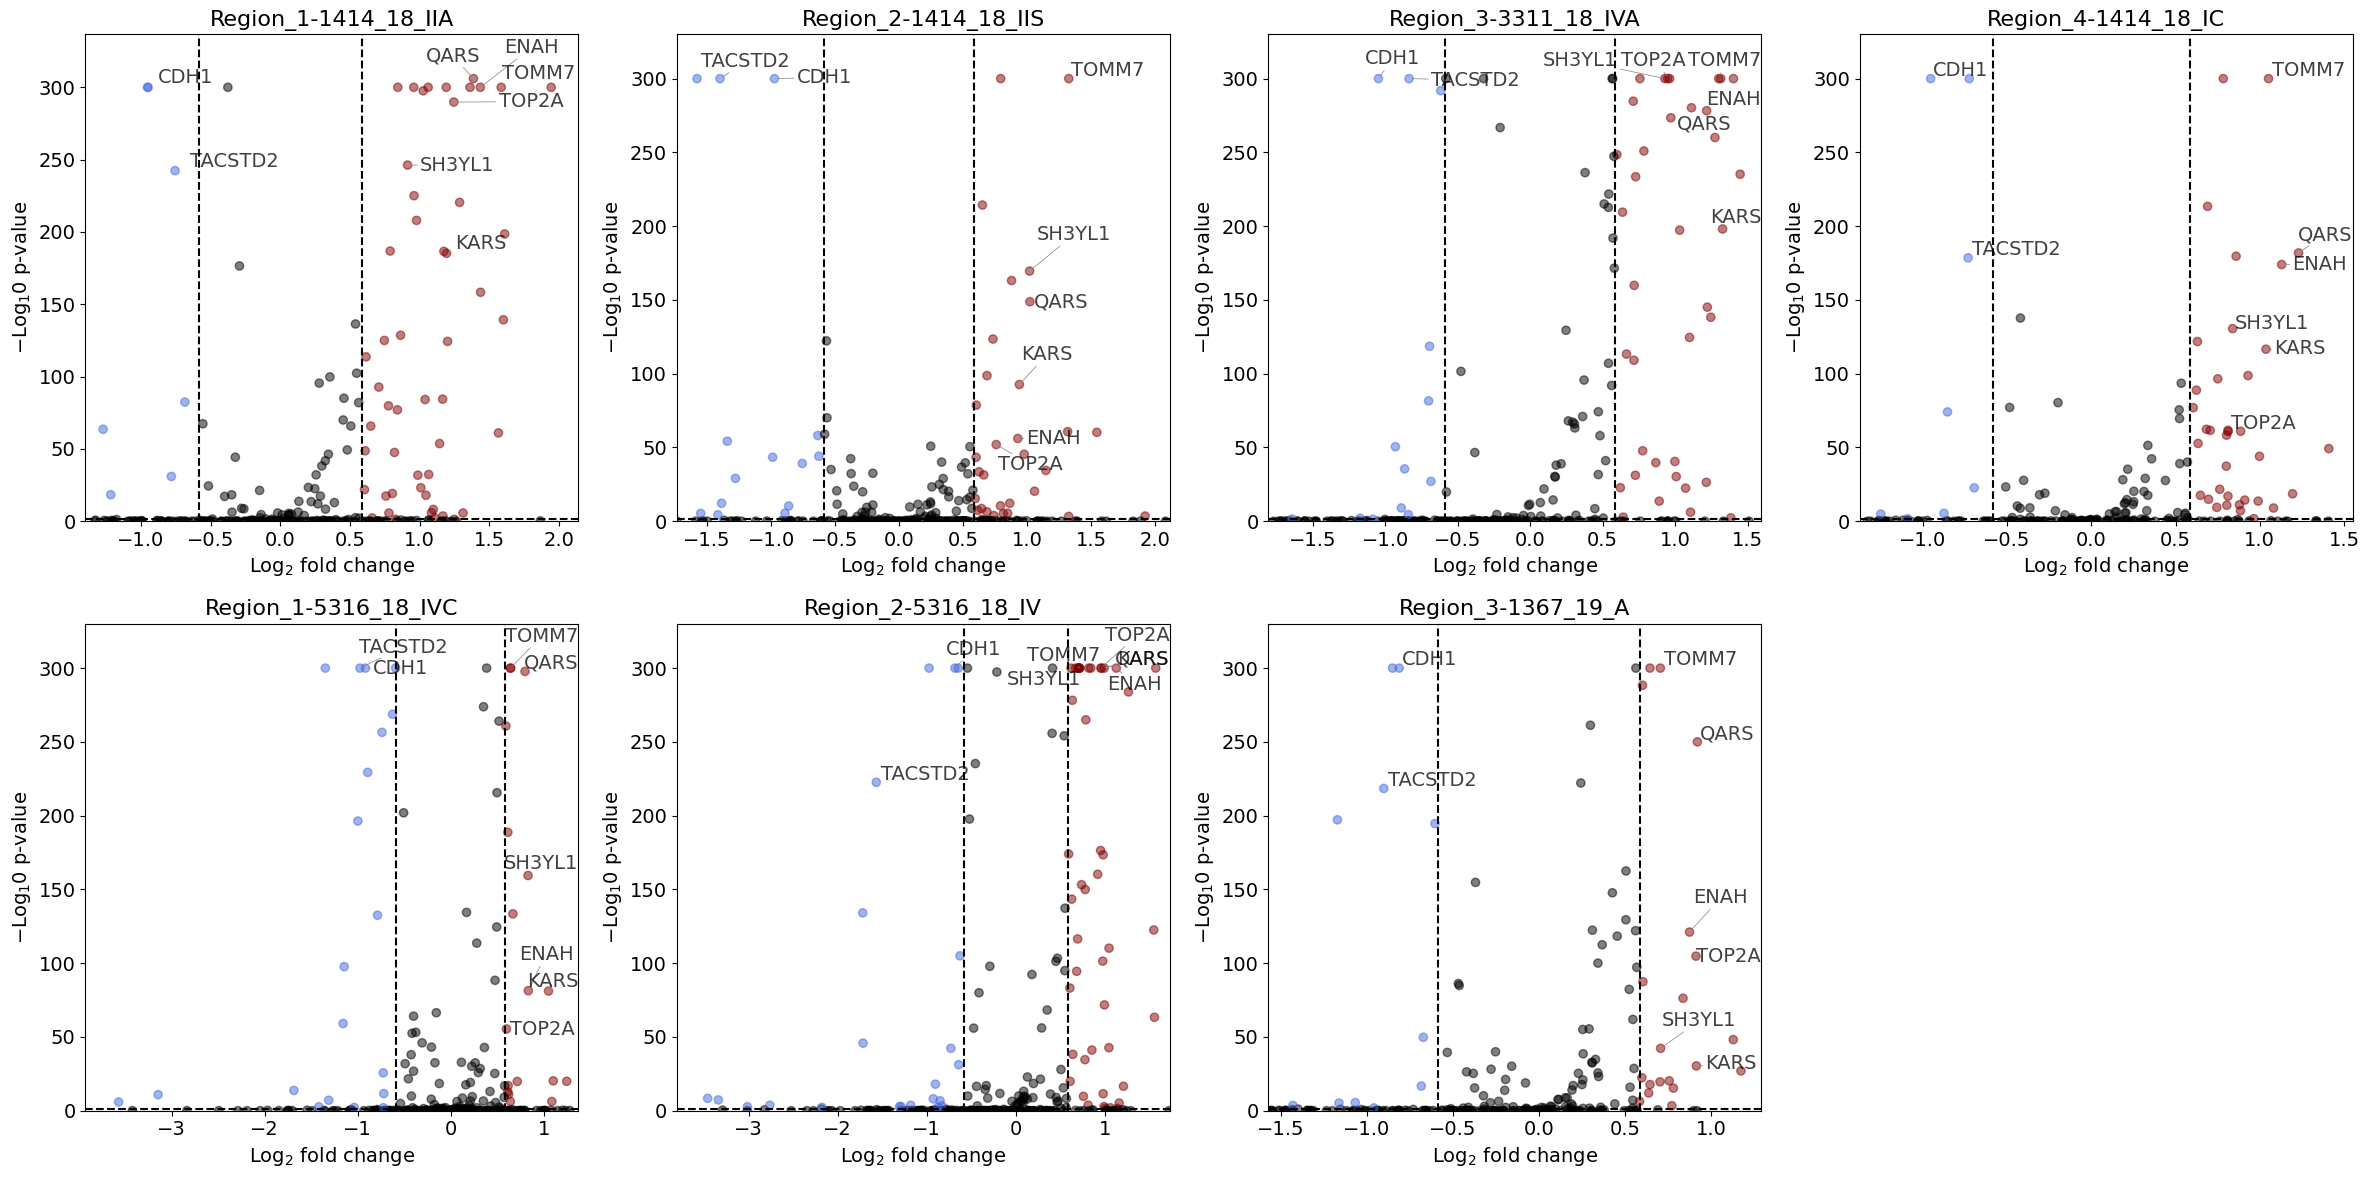

Cancer cell 2


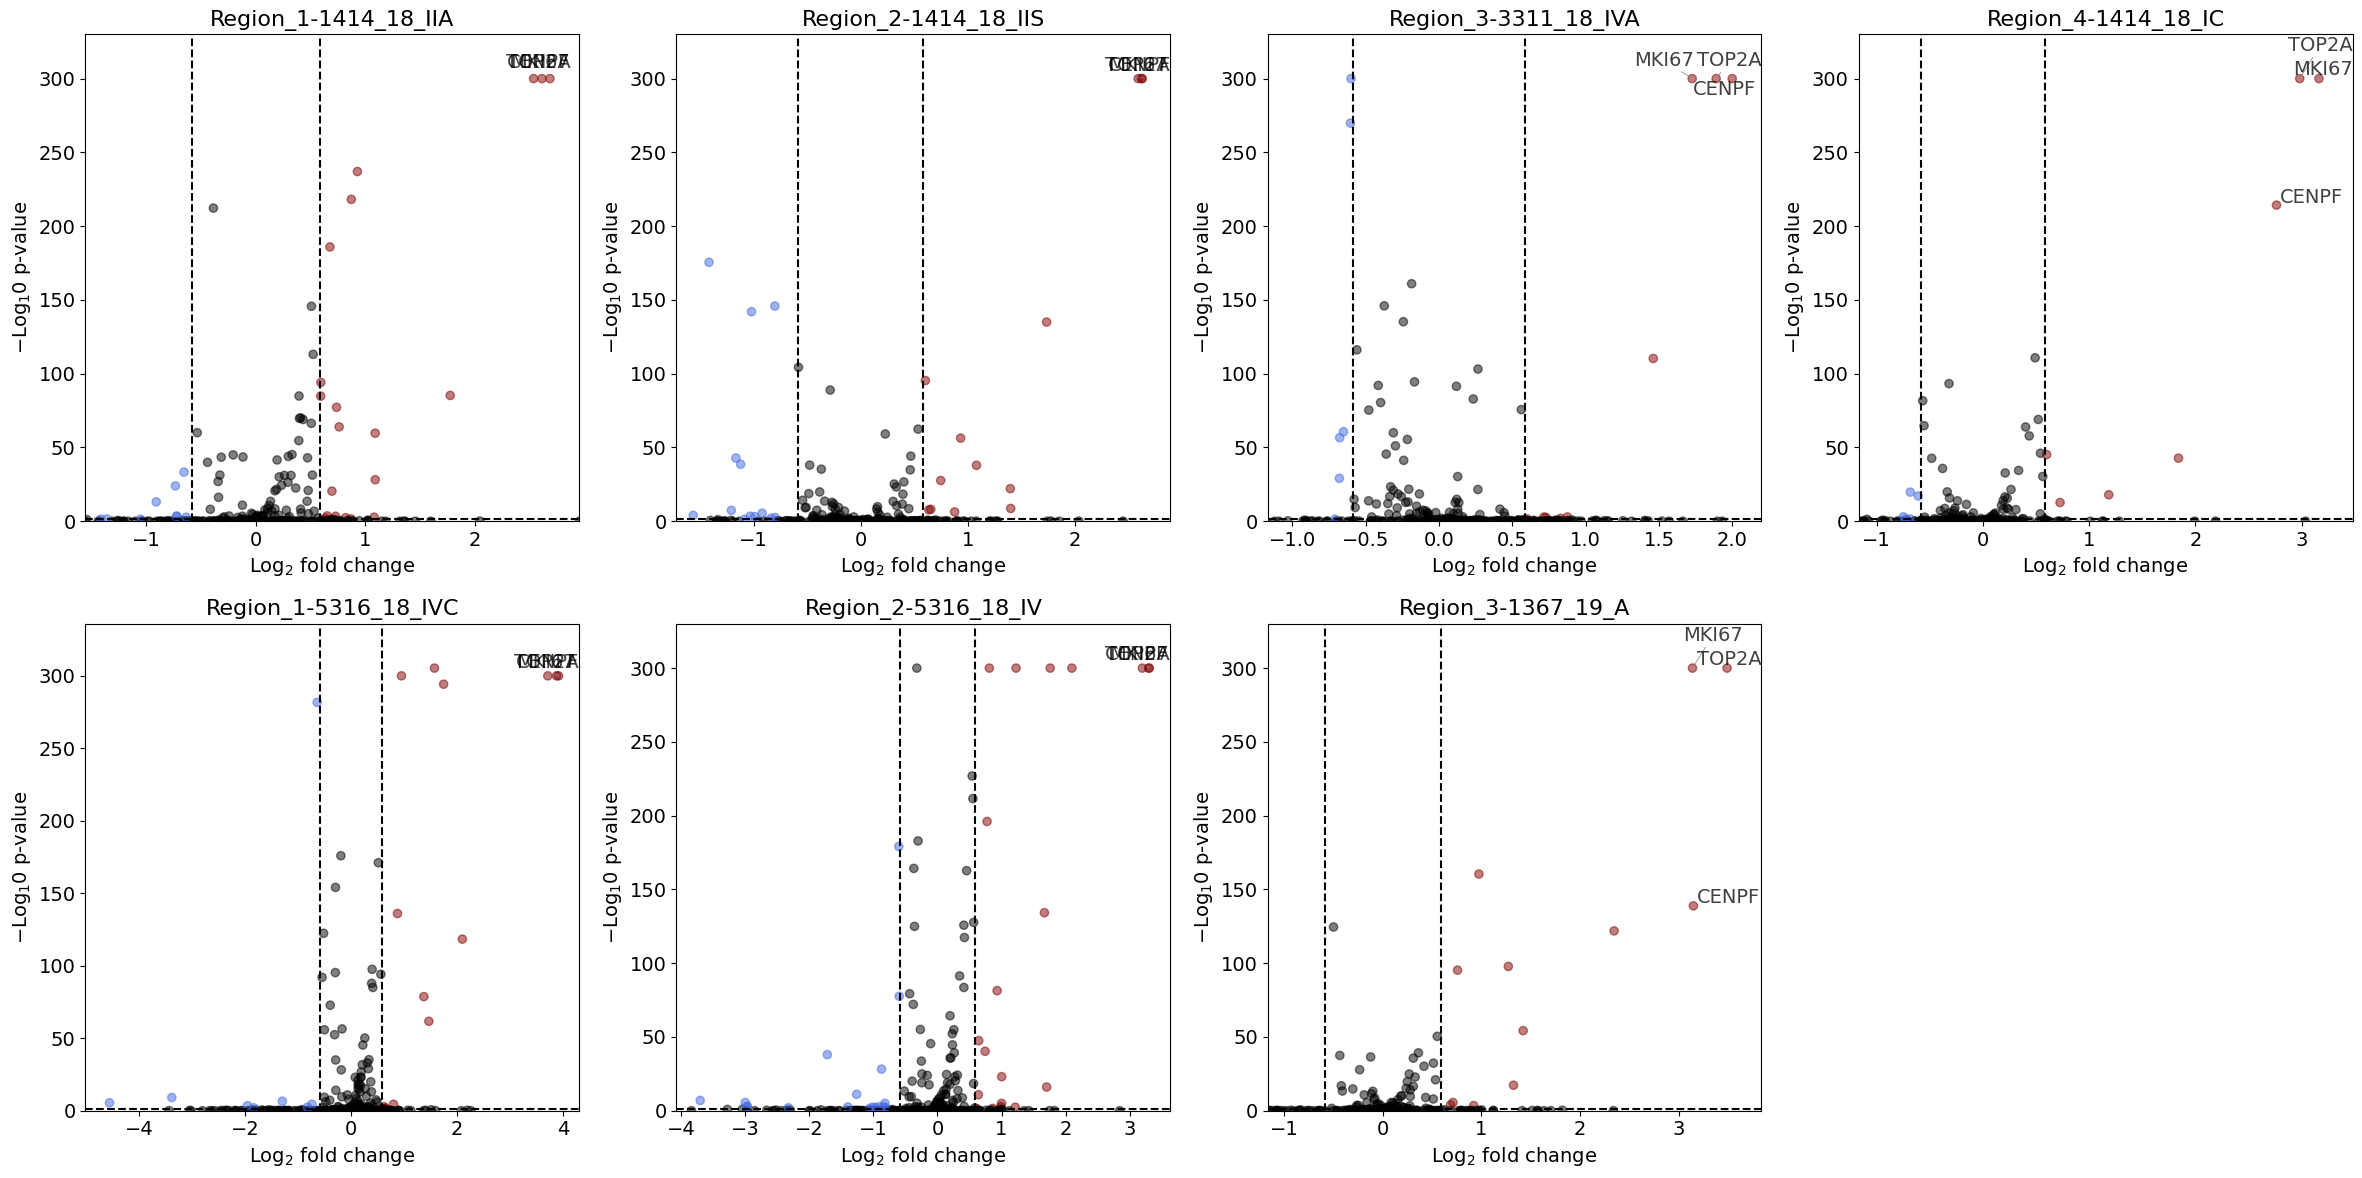

Cancer cell 3


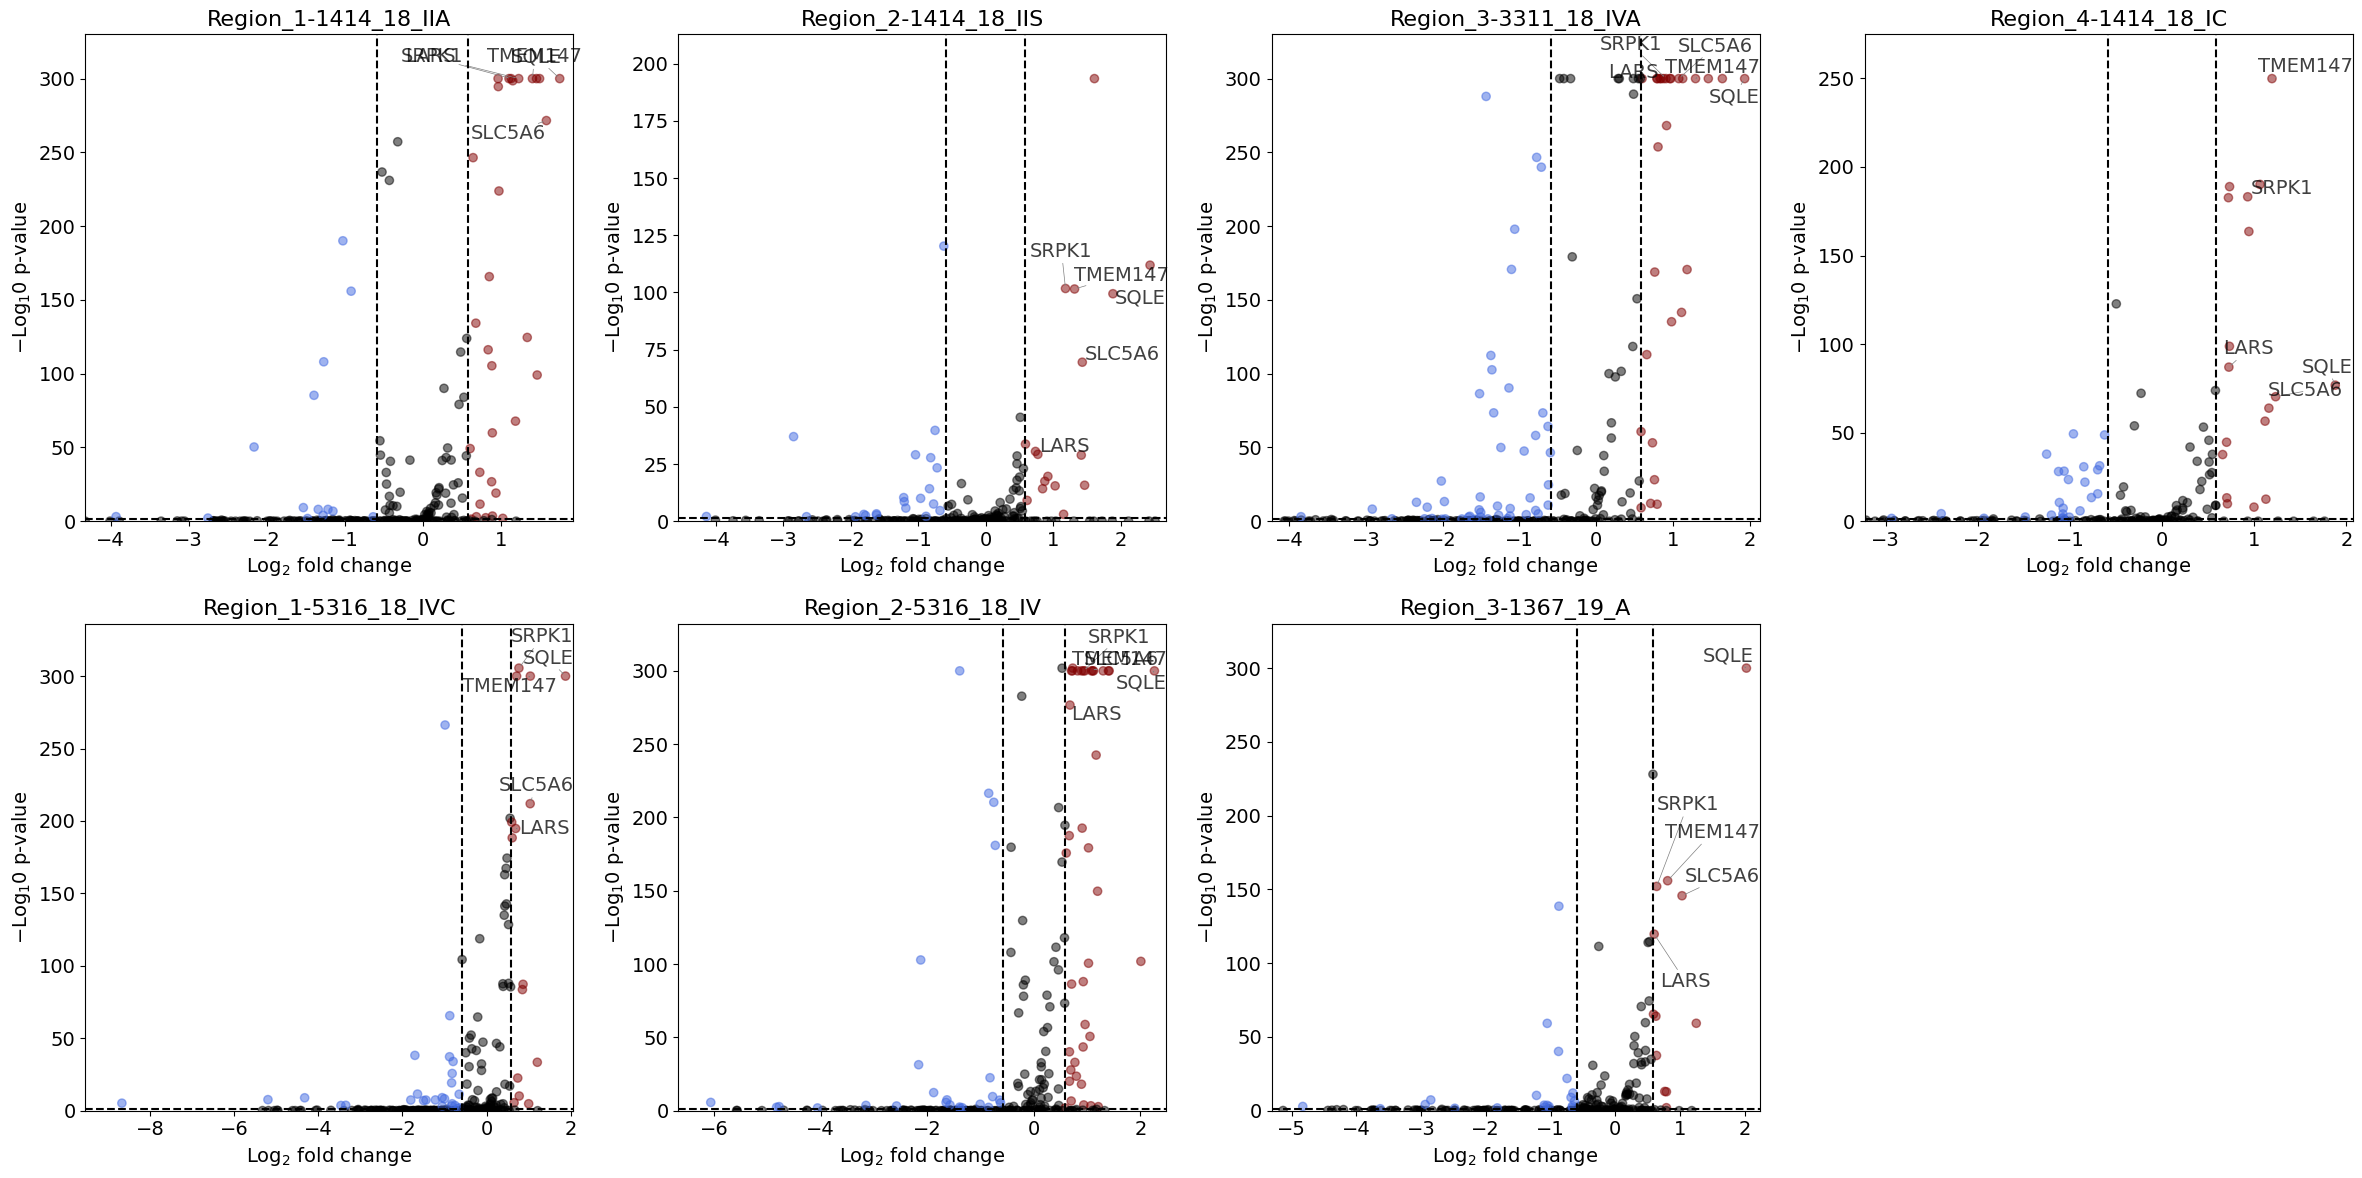

Cancer cell 4


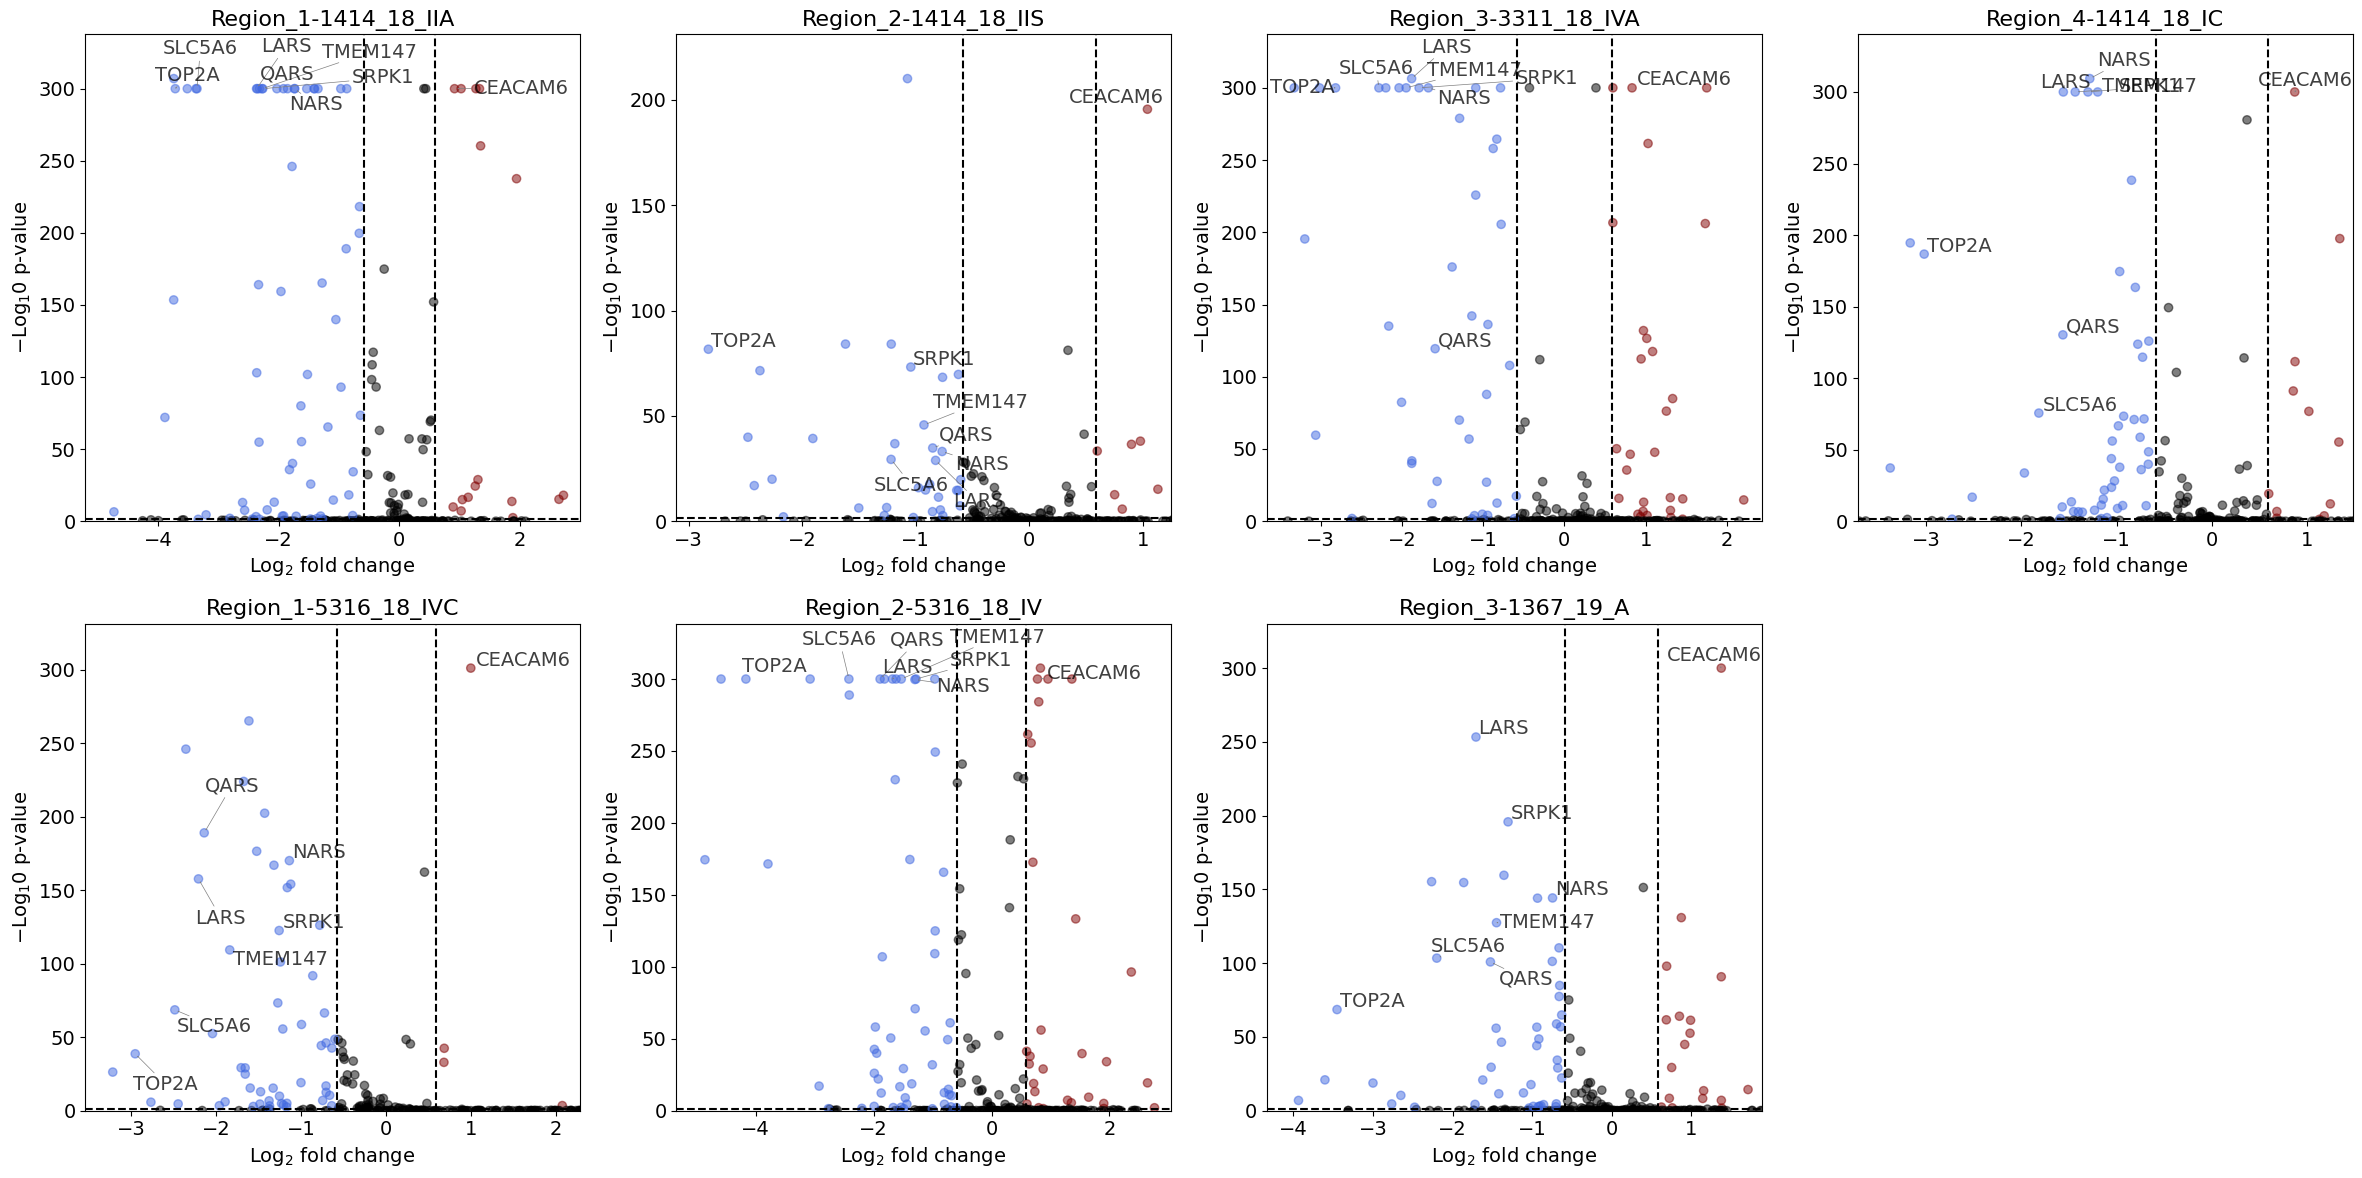

Cancer cell 5


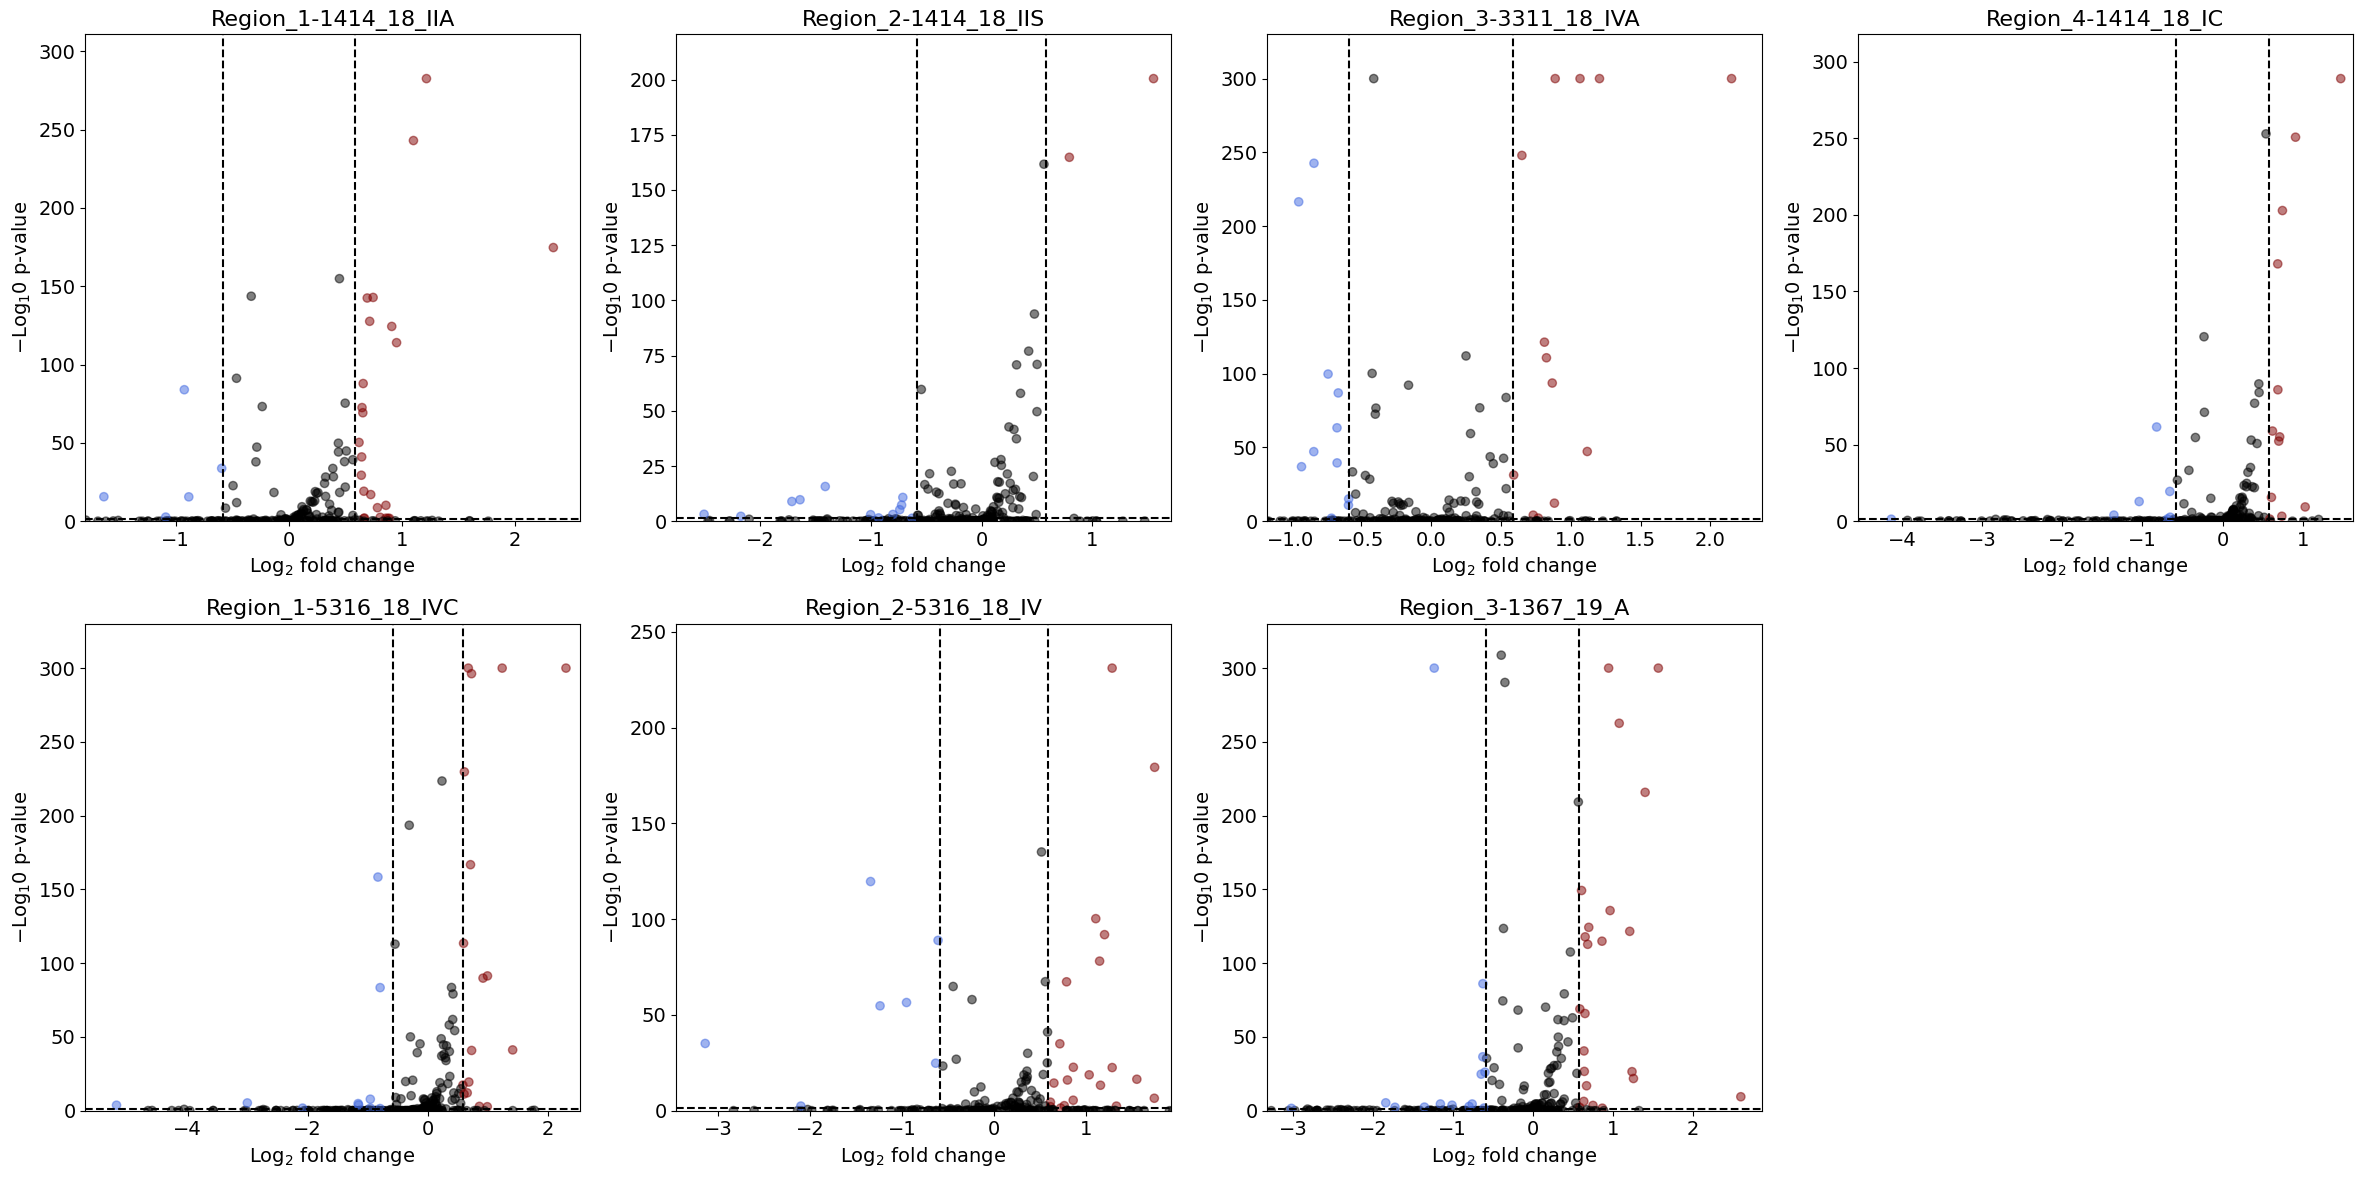

Cancer cell 6


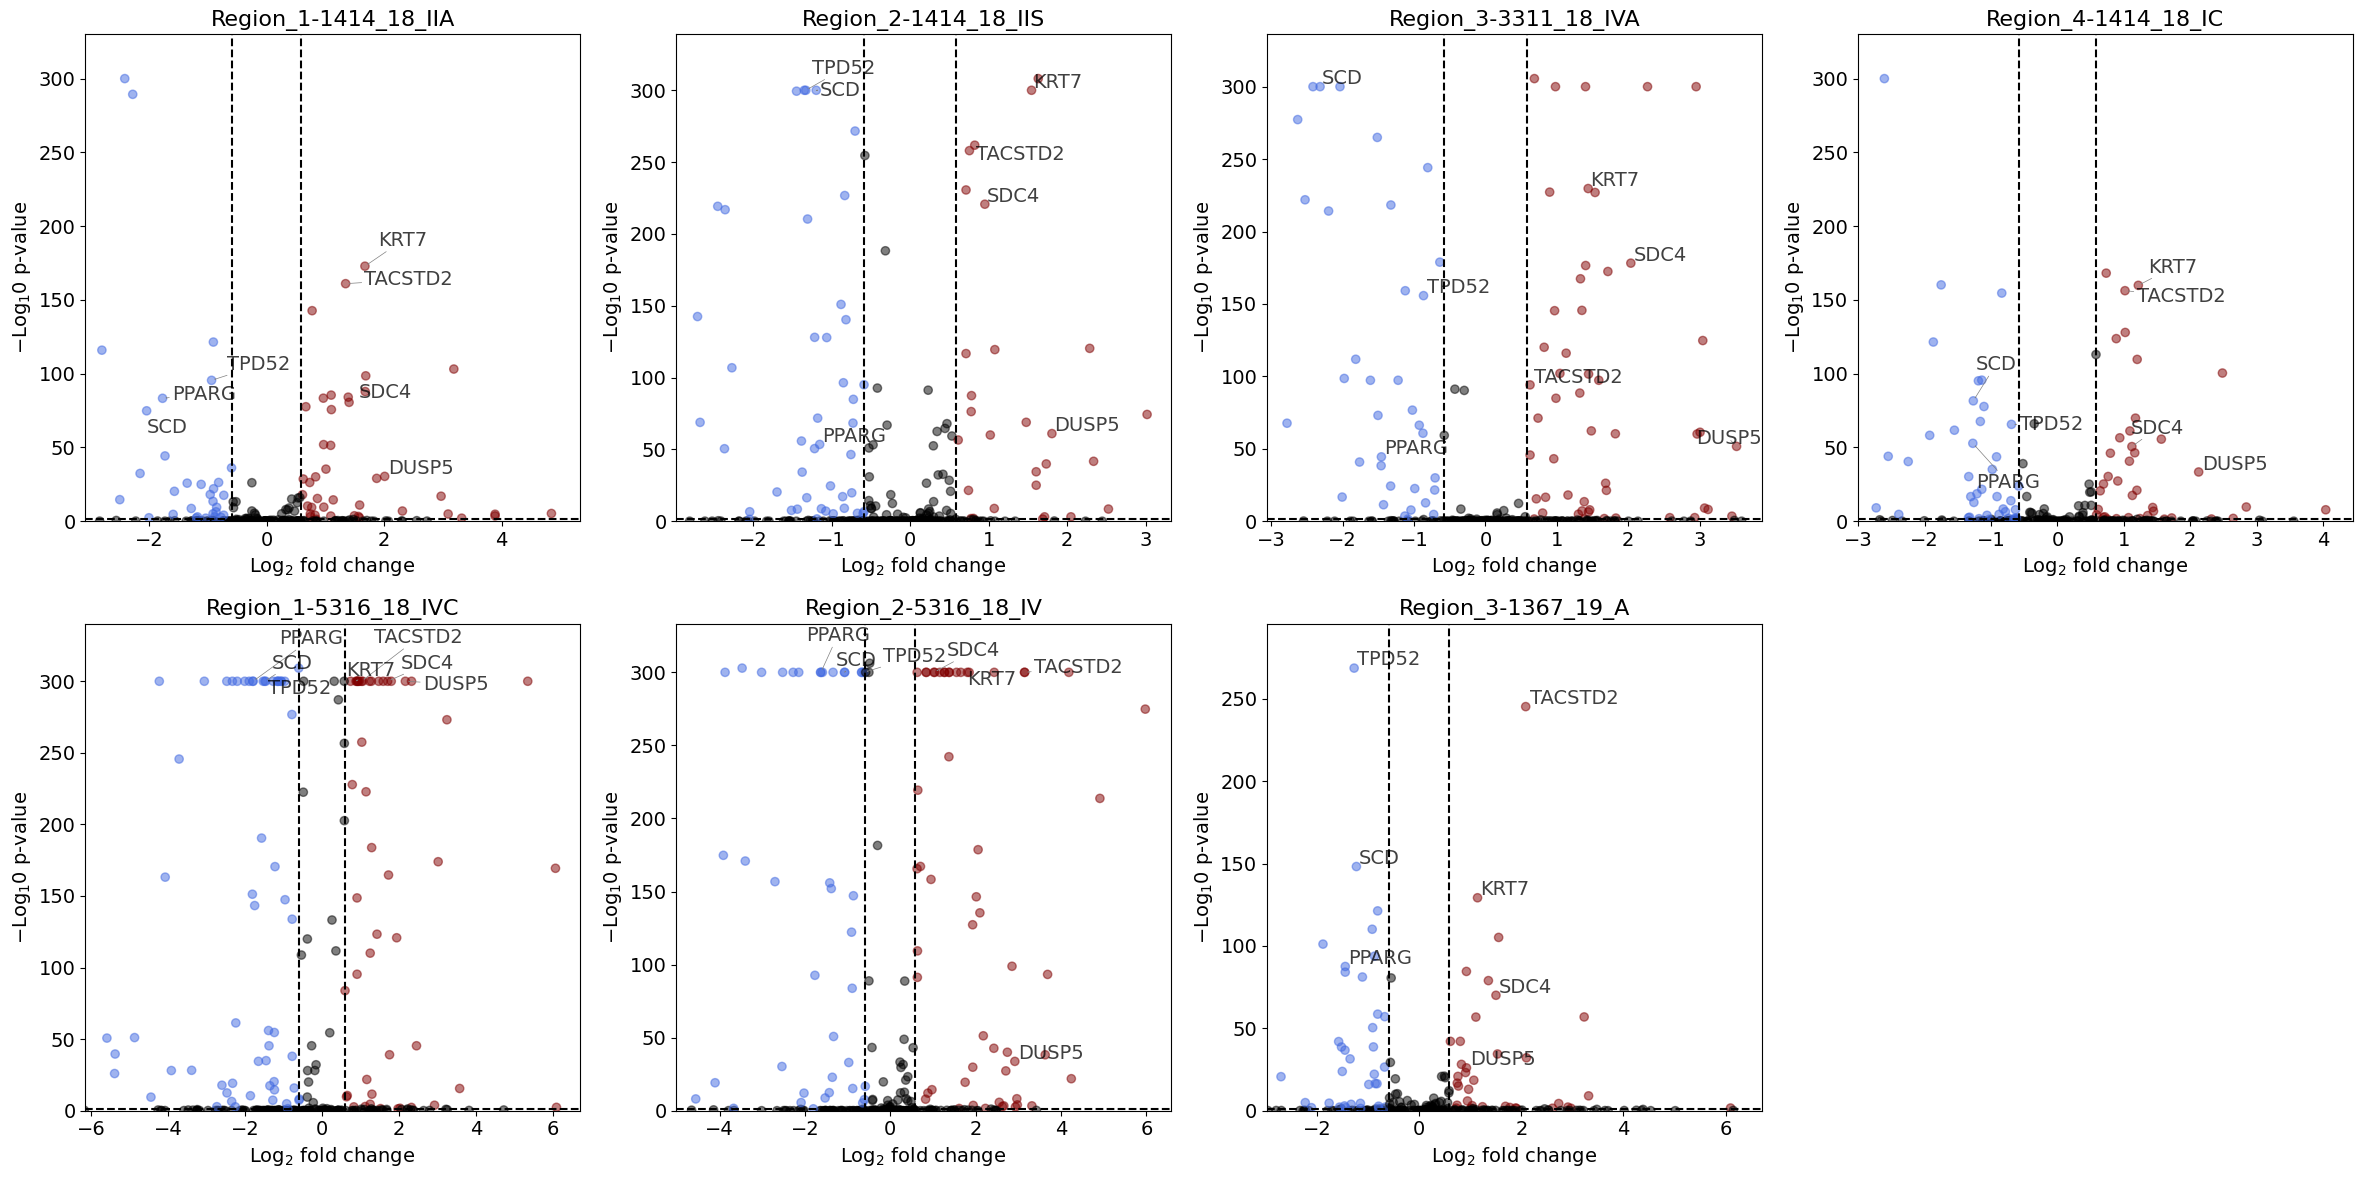

Cancer cell 7


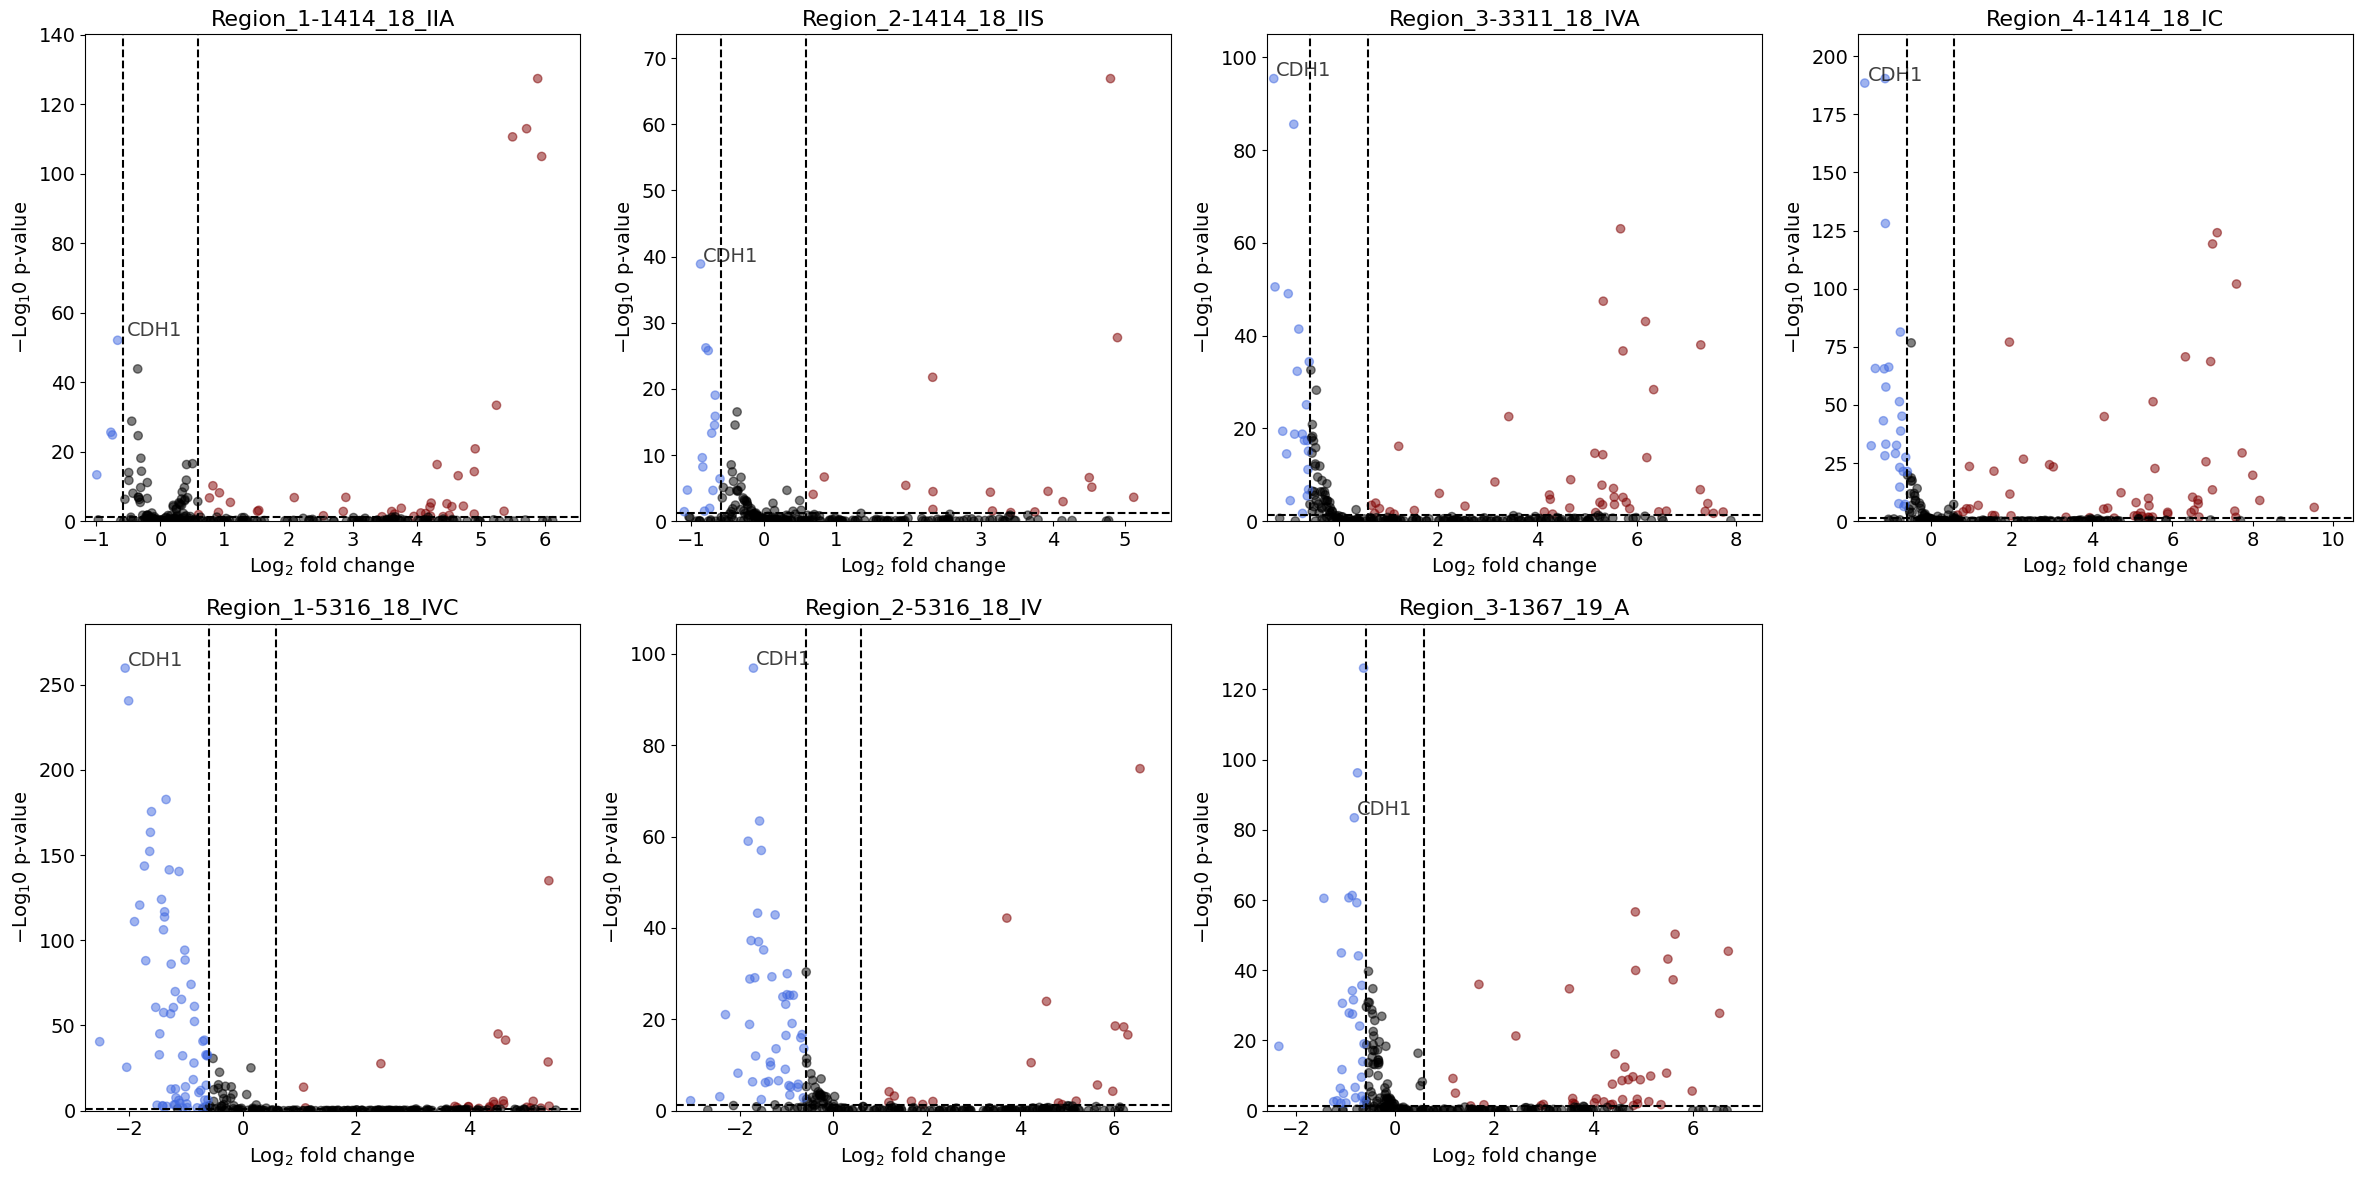

In [64]:
for cell_type in cell_types:
    print(cell_type, flush=True)
    n_plots, n_rows, n_cols = get_nrows_maxcols(n_keys=len(deg_results), max_cols=4)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
    axs = axs.ravel()

    if cell_type in up_genes_dict:
        up_genes = up_genes_dict[cell_type]
    else:
        up_genes = []

    if cell_type in down_genes_dict:
        down_genes = down_genes_dict[cell_type]
    else:
        down_genes = []

    genes_to_label = up_genes + down_genes

    for i, (k, d) in enumerate(deg_results.items()):
        df = d[cell_type]

        volcano_plot(
            data=df,
            label_top_n=up_genes + down_genes,
            fold_change_threshold=1.5,
            show=False,
            ax=axs[i]
            )

        axs[i].set_title(k)

    remove_empty_subplots(axes=axs, nplots=n_plots, nrows=n_rows, ncols=n_cols)

    plt.savefig(f"figures/volcano_all_regions_{cell_type}.pdf")
    plt.show()